In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import subprocess
import os
import random
import math
import time
import plotly.express as px

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.ML.Cluster import Butina

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')  

import matplotlib
from matplotlib import rc
font = {'size'   : 8}
matplotlib.rc('font', **font)

# change font
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

# Part 1: Define functions to make PCA & tSNE

In [2]:
def pca_tsne_mols(fp_list, fp_labels, colors_for_vis, num_components = 2048):
    # PCA first
    pca = PCA(n_components=2)
    crds = pca.fit_transform(fp_list)

    print('variance explained by pc1+pc2: ' + str(np.sum(pca.explained_variance_ratio_)))

    crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
    crds_df['label'] = fp_labels
    crds_df.head()

    plt.figure(figsize=(5,5), dpi = 300)
    ax = sns.scatterplot(data=crds_df,x="PC_1",y="PC_2",hue="label", alpha = 0.7, s = 10, palette=colors_for_vis)
    
    # TSNE next
    pca = PCA(n_components=num_components)
    crds = pca.fit_transform(fp_list)

    crds_embedded = TSNE(n_components=2).fit_transform(crds)

    tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
    tsne_df['label'] = fp_labels

    plt.figure(figsize=(5,5), dpi = 300)
    ax = sns.scatterplot(data=tsne_df,x="X",y="Y",hue="label", alpha = 0.7,  s = 10, palette=colors_for_vis)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()
    
    return(tsne_df)

# Part 2: Read in and process all possible datasets for comparisons

In [3]:
# take in primary screen data
df = pd.read_excel('../data/TrainingDataRound1_wValidation.xlsx')
print('num drugs: ' + str(len(df)))
thresh = 0.2
secondchoice = list((df['Rep1_Inhibition'] < thresh) & (df['Rep2_Inhibition'] < thresh))
test = list(df['Inhibition Hit'])
corrected = []
for i in range(len(test)):
    if test[i] == 1.0:
        corrected.append(True)
    elif test[i] == 0.0:
        corrected.append(False)
    else:
        corrected.append(secondchoice[i])
df['inh_hit'] = corrected
df['kill_hit'] = [True if x == 1.0 else False for x in list(df['Killing Hit'])]

df = df[['SMILES', 'Name', 'inh_hit', 'kill_hit']]

# add in 16 validated killing ML predictions
small = pd.read_excel('../data/800kPredictionTestingData.xlsx', header = 0)
small = small.dropna(subset=['GI_Validation', 'Killing_Validation'])
inh_thresh = 0.2
kill_thresh = 4.37e6
small['hit_inh'] = [1.0 if i < inh_thresh else 0.0 for i in small['GI_Validation']]
small['hit_kill'] = [1.0 if i < kill_thresh else 0.0 for i in small['Killing_Validation']]
small = small[['SMILES', 'Name', 'hit_inh', 'hit_kill']]
small.columns = ['SMILES', 'Name', 'inh_hit', 'kill_hit']

df = df.append(small)

nonhits = df[(df['inh_hit'] == 0) & (df['kill_hit'] == 0)]
print('non_hits', len(nonhits))
nonhits = nonhits[[type(x) != float for x in list(nonhits['SMILES'])]]
nh_smiles = list(nonhits['SMILES'])
nh_mols = [Chem.MolFromSmiles(x) for x in nh_smiles]
nonhit_fps, nh_names = zip(*[(Chem.RDKFingerprint(x),y) for x,y in zip(nh_mols,list(nonhits['Name'])) if x is not None])

kill_hits_only = df[(df['kill_hit'] == 1) & (df['inh_hit'] == 0)]
print('kill_hits_only', len(kill_hits_only))
kill_hits_only_smiles = list(kill_hits_only['SMILES'])
kill_hits_only_mols = [Chem.MolFromSmiles(x) for x in kill_hits_only_smiles]
kill_hits_only_fps, kill_hits_only_names = zip(*[(Chem.RDKFingerprint(x),y) for x,y in zip(kill_hits_only_mols,list(kill_hits_only['Name'])) if x is not None])

inh_hits_only = df[(df['kill_hit'] == 0) & (df['inh_hit'] == 1)]
print('inh_hits_only', len(inh_hits_only))
inh_hits_only_smiles = list(inh_hits_only['SMILES'])
inh_hits_only_mols = [Chem.MolFromSmiles(x) for x in inh_hits_only_smiles]
inh_hits_only_fps, inh_hits_only_names = zip(*[(Chem.RDKFingerprint(x),y) for x,y in zip(inh_hits_only_mols,list(inh_hits_only['Name'])) if x is not None])

both_hits = df[(df['kill_hit'] == 1) & (df['inh_hit'] == 1)]
print('both_hits', len(both_hits))
both_hits_smiles = list(both_hits['SMILES'])
both_hits_mols = [Chem.MolFromSmiles(x) for x in both_hits_smiles]
both_hits_fps, both_hits_names = zip(*[(Chem.RDKFingerprint(x),y) for x,y in zip(both_hits_mols,list(both_hits['Name'])) if x is not None])

# get morgan fingerprints for abx
abx = pd.read_csv('../data/curated_set_of_566_abx.csv')
abx = abx[[type(x) != float for x in list(abx['Smiles'])]]
abx_smiles = list(abx['Smiles'])
mols = [Chem.MolFromSmiles(x) for x in abx_smiles]
abx_fps, abx_names, abx_classes = zip(*[(Chem.RDKFingerprint(x),y,z) for x,y,z in zip(mols,list(abx['Name']),list(abx['Class-Annotated'])) if x is not None])


num drugs: 6720


/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_13158/1415429627.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(small)
/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_13158/1415429627.py:30: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = df.append(small)


non_hits 6668
kill_hits_only 28
inh_hits_only 92
both_hits 72


In [4]:
fp_list = list(nonhit_fps)
fp_list.extend(abx_fps)
fp_list.extend(kill_hits_only_fps)
fp_list.extend(inh_hits_only_fps)
fp_list.extend(both_hits_fps)

fp_labels = ['Non-Hits'] * len(nonhit_fps)
fp_labels.extend(['Known Antibiotics'] * len(abx_fps))
fp_labels.extend(['Stat Phase Lethal Activity Only'] * len(kill_hits_only_fps))
fp_labels.extend(['Growth Inhibition Activity Only'] * len(inh_hits_only_fps))
fp_labels.extend(['Both Inhibition and Lethality Activity'] * len(both_hits_fps))

# Part 3: Perform PCA and t-SNE

variance explained by pc1+pc2: 0.2090586936151517


/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


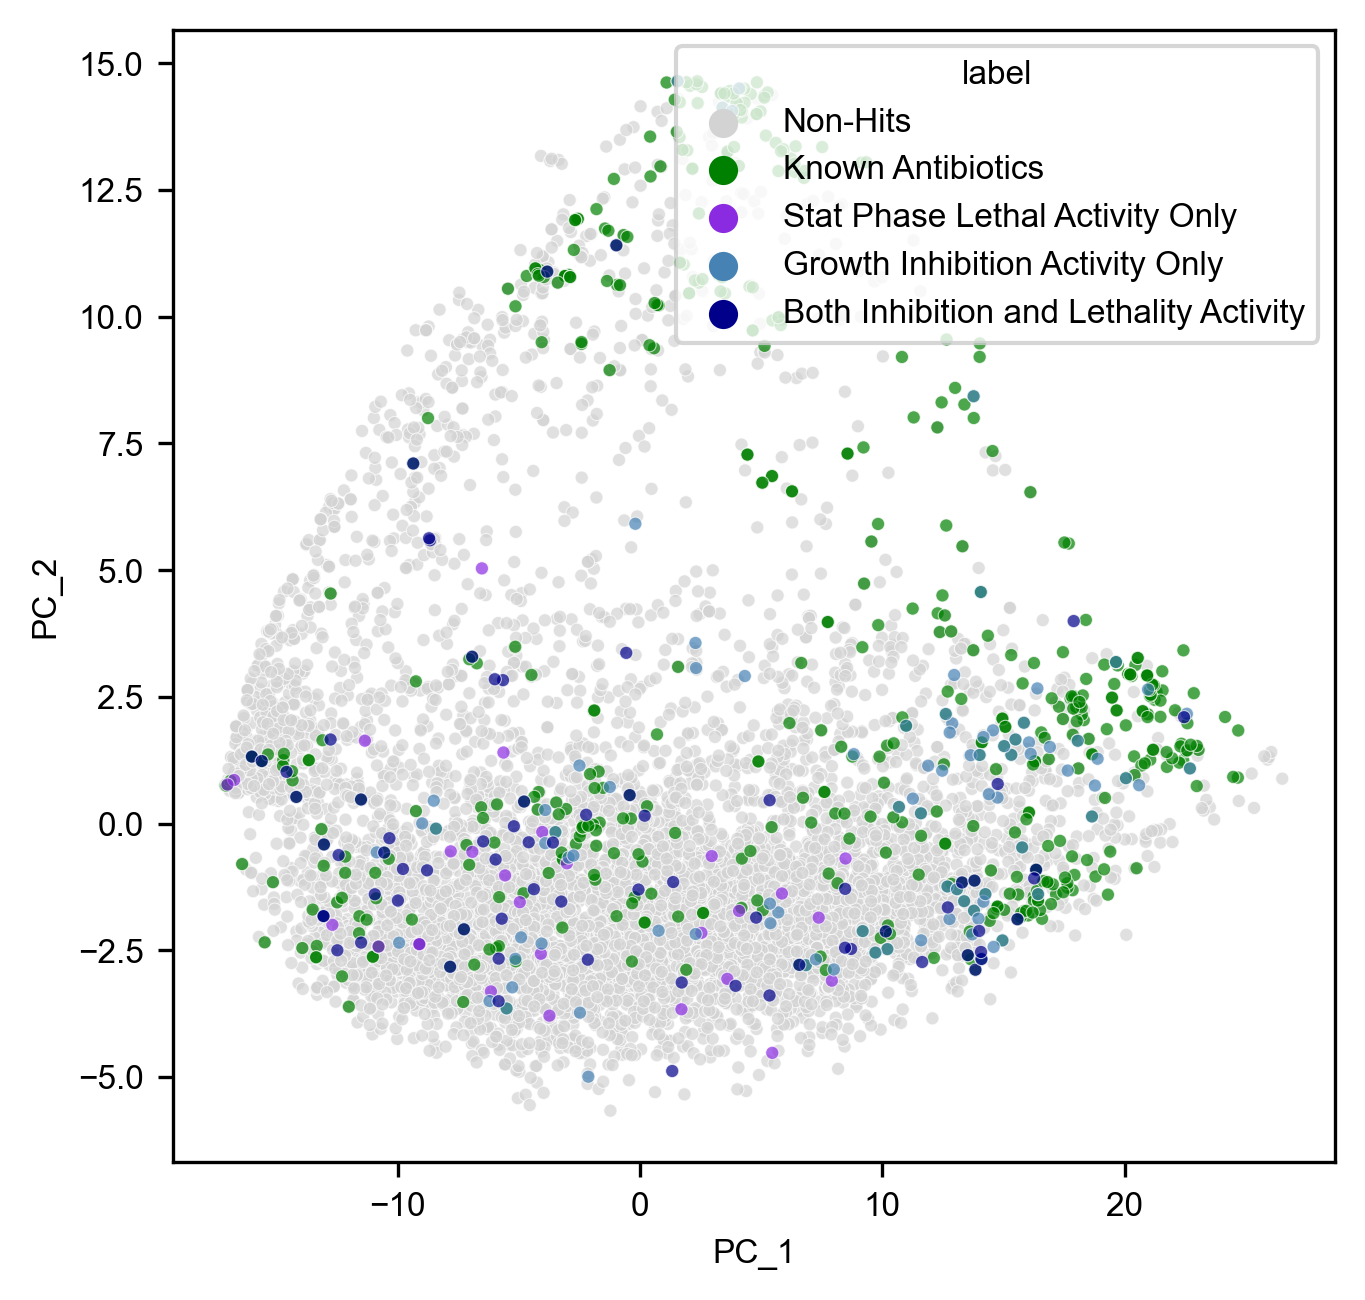

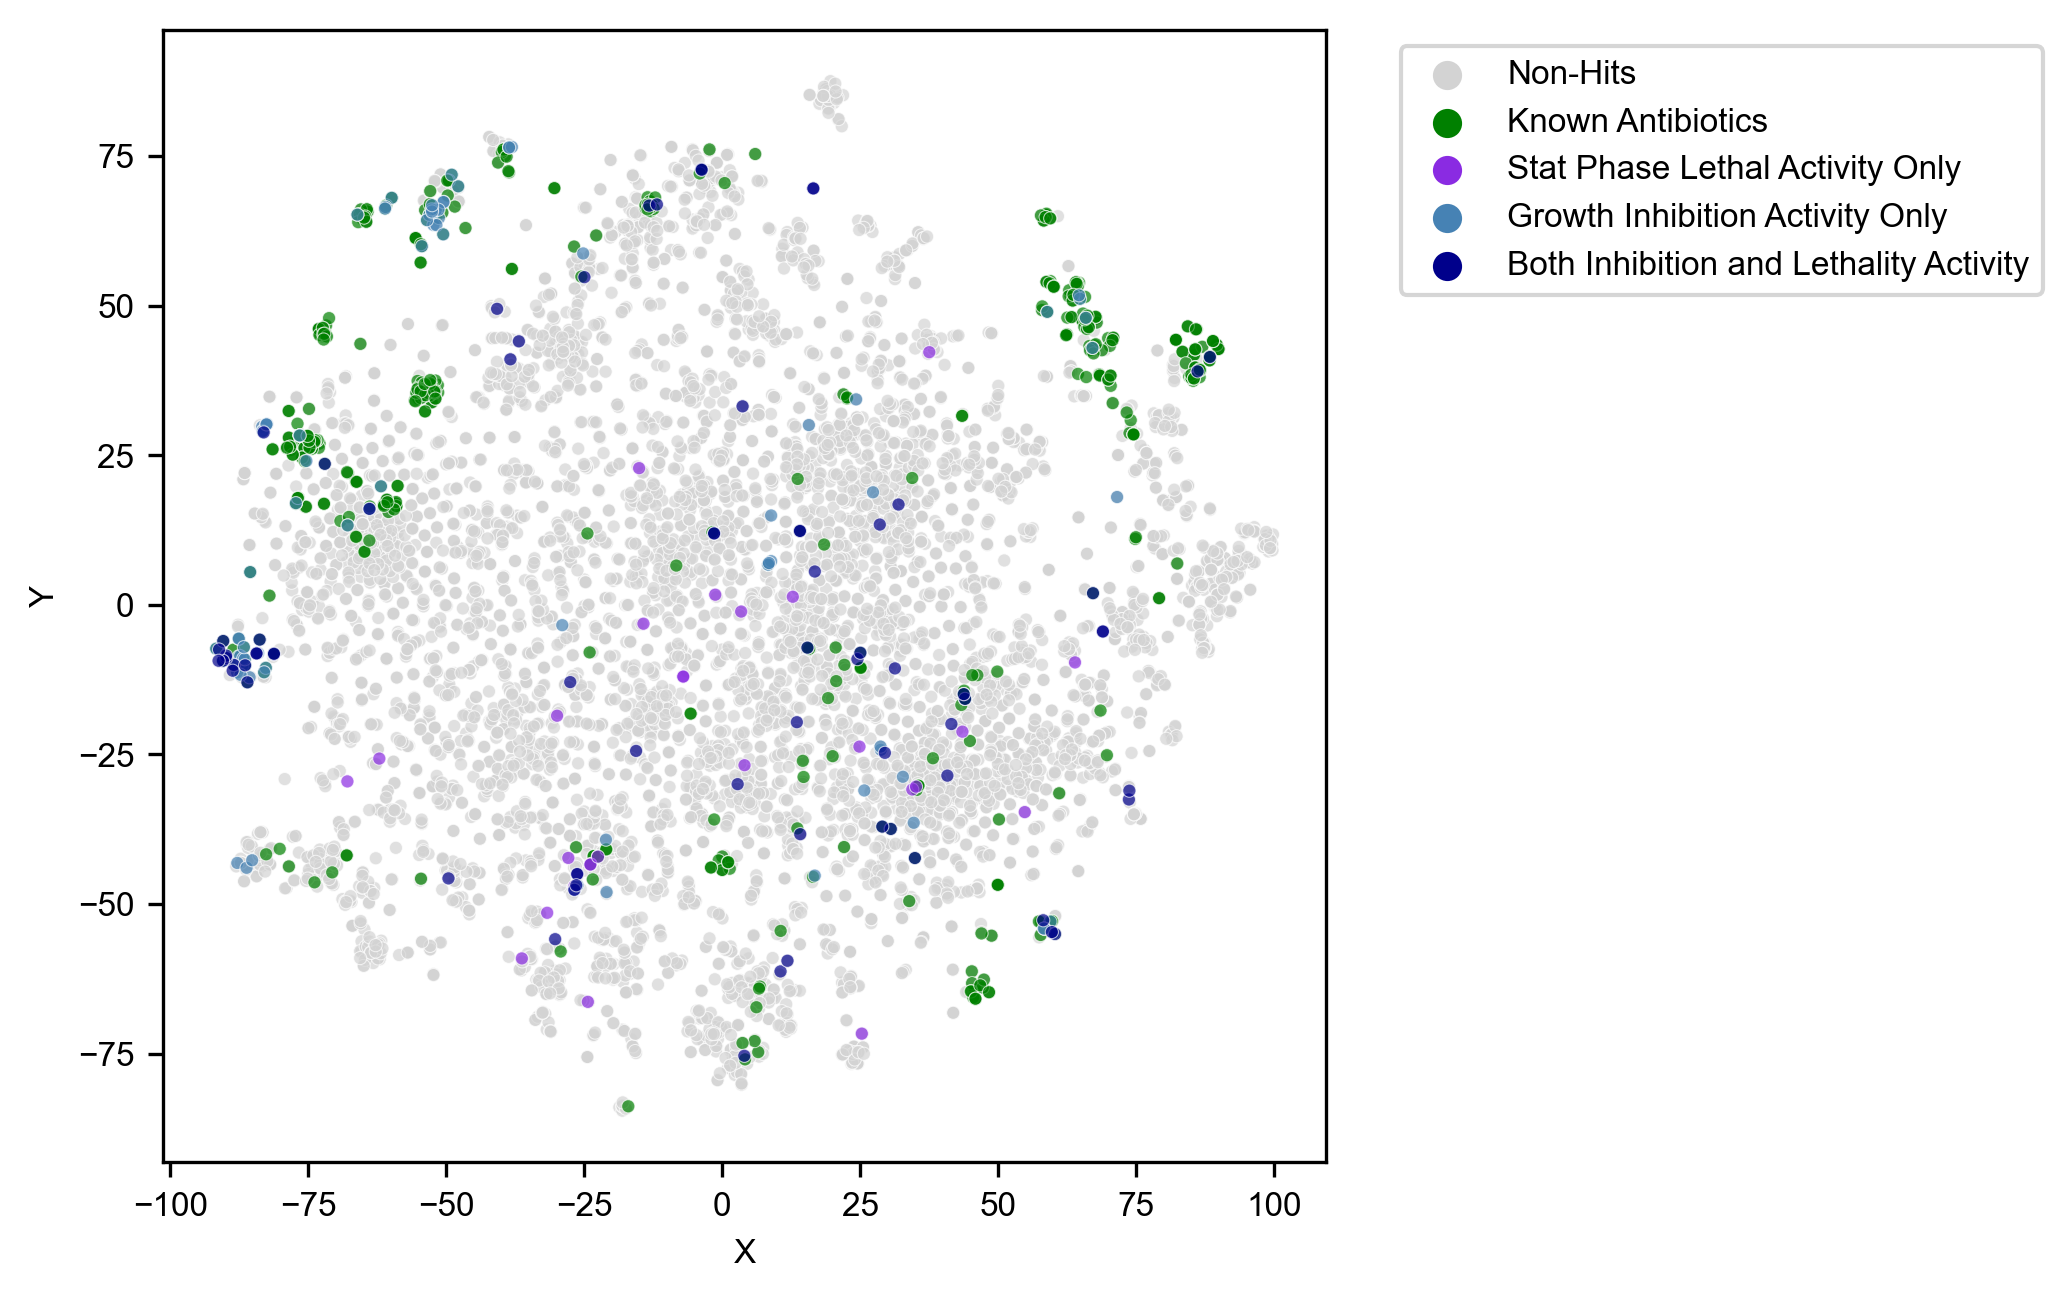

In [5]:
colors_for_vis = ['lightgray','green','blueviolet', 'steelblue','darkblue']
tsne_df = pca_tsne_mols(fp_list, fp_labels, colors_for_vis)

# Part 4: Get additional information for interactive display

In [6]:
name_list = list(nh_names)
name_list.extend(abx_names)
name_list.extend(kill_hits_only_names)
name_list.extend(inh_hits_only_names)
name_list.extend(both_hits_names)

smis_list = list(nh_smiles)
smis_list.extend(abx_smiles)
smis_list.extend(kill_hits_only_smiles)
smis_list.extend(inh_hits_only_smiles)
smis_list.extend(both_hits_smiles)

testdf = tsne_df
testdf['Name'] = name_list
testdf['SMILES'] = smis_list

# clean up display so only 2 dec
abx = abx[['Smiles', 'Class-Annotated']]
abx = abx.drop_duplicates('Smiles')
testdf = testdf.merge(abx, left_on = 'SMILES', right_on = 'Smiles', how = 'left')
testdf = testdf.fillna('N/A')

In [7]:
testdf

X          Y                                   label  \
0    -24.402592 -50.870075                                Non-Hits   
1     20.533625 -12.655523                                Non-Hits   
2    -27.365353  42.727612                                Non-Hits   
3    -30.267717 -56.957058                                Non-Hits   
4    -28.526775  11.265196                                Non-Hits   
...         ...        ...                                     ...   
7412 -91.167717  -7.469370  Both Inhibition and Lethality Activity   
7413  43.759823 -14.914922  Both Inhibition and Lethality Activity   
7414 -26.449127 -46.855495  Both Inhibition and Lethality Activity   
7415 -91.249268  -9.343479  Both Inhibition and Lethality Activity   
7416 -30.271477 -55.863186  Both Inhibition and Lethality Activity   

               Name                                             SMILES  \
0          EHop-016     CCn1c2ccccc2c2cc(Nc3ccnc(NCCCN4CCOCC4)n3)ccc12   
1      hydroquinone                                       Oc1ccc(O)cc1   
2        serdemetan           C(Cc1c[nH]c2ccccc12)Nc1ccc(Nc2ccncc2)cc1   
3              DBeQ             C(Nc1nc(NCc2ccccc2)c2ccccc2n1)c1ccccc1   
4       elacestrant  CCNCCc1ccc(CN(CC)c2cc(OC)ccc2[C@@H]2CCc3cc(O)c...   
...             ...                                                ...   
7412  BRD-K38903973  COc1c(c(cc2c1N(C=C(C(=O)O)C2=O)C1CC1)F)CN1CC[C...   
7413  BRD-K23481365                       CCCCCCCCCCCCCCCC[N+](C)(C)CC   
7414  BRD-A37809964     O[C@@H](CNC1CCCC1)Cn1c2ccc(cc2c2cc(ccc12)Cl)Cl   
7415  BRD-K71926323    CN1CCN(CC1)c1c(cc2c3c1OCN(C)N3C=C(C(=O)O)C2=O)F   
7416  BRD-K17140735     CC(C)c1ccc(cc1)Cn1ccc2c1ccc1nc(nc(c12)N)NC1CC1   

                            Smiles       Class-Annotated  
0                              N/A                   N/A  
1                              N/A                   N/A  
2                              N/A                   N/A  
3                              N/A                   N/A  
4                              N/A                   N/A  
...                            ...                   ...  
7412                           N/A                   N/A  
7413  CCCCCCCCCCCCCCCC[N+](C)(C)CC  anti-septic/membrane  
7414                           N/A                   N/A  
7415                           N/A                   N/A  
7416                           N/A                   N/A  

[7417 rows x 7 columns]

In [8]:
# actually make the interactive plot
hover_labels = ['X', 'Y', 'label', 'Name', 'SMILES', 'Class-Annotated']
hover_bools = [True, True, True, True, True, True]

fig = px.scatter(testdf, x = 'X', y = 'Y', opacity = 0.75, color =  testdf['label'], hover_data = dict(zip(hover_labels, hover_bools)), color_discrete_sequence=colors_for_vis)
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [9]:
testdf.to_csv('../out/tsne_data_plus_annotated_mechanism_plus_val_ML_mols.csv', index = False)
testdf

X          Y                                   label  \
0    -24.402592 -50.870075                                Non-Hits   
1     20.533625 -12.655523                                Non-Hits   
2    -27.365353  42.727612                                Non-Hits   
3    -30.267717 -56.957058                                Non-Hits   
4    -28.526775  11.265196                                Non-Hits   
...         ...        ...                                     ...   
7412 -91.167717  -7.469370  Both Inhibition and Lethality Activity   
7413  43.759823 -14.914922  Both Inhibition and Lethality Activity   
7414 -26.449127 -46.855495  Both Inhibition and Lethality Activity   
7415 -91.249268  -9.343479  Both Inhibition and Lethality Activity   
7416 -30.271477 -55.863186  Both Inhibition and Lethality Activity   

               Name                                             SMILES  \
0          EHop-016     CCn1c2ccccc2c2cc(Nc3ccnc(NCCCN4CCOCC4)n3)ccc12   
1      hydroquinone                                       Oc1ccc(O)cc1   
2        serdemetan           C(Cc1c[nH]c2ccccc12)Nc1ccc(Nc2ccncc2)cc1   
3              DBeQ             C(Nc1nc(NCc2ccccc2)c2ccccc2n1)c1ccccc1   
4       elacestrant  CCNCCc1ccc(CN(CC)c2cc(OC)ccc2[C@@H]2CCc3cc(O)c...   
...             ...                                                ...   
7412  BRD-K38903973  COc1c(c(cc2c1N(C=C(C(=O)O)C2=O)C1CC1)F)CN1CC[C...   
7413  BRD-K23481365                       CCCCCCCCCCCCCCCC[N+](C)(C)CC   
7414  BRD-A37809964     O[C@@H](CNC1CCCC1)Cn1c2ccc(cc2c2cc(ccc12)Cl)Cl   
7415  BRD-K71926323    CN1CCN(CC1)c1c(cc2c3c1OCN(C)N3C=C(C(=O)O)C2=O)F   
7416  BRD-K17140735     CC(C)c1ccc(cc1)Cn1ccc2c1ccc1nc(nc(c12)N)NC1CC1   

                            Smiles       Class-Annotated  
0                              N/A                   N/A  
1                              N/A                   N/A  
2                              N/A                   N/A  
3                              N/A                   N/A  
4                              N/A                   N/A  
...                            ...                   ...  
7412                           N/A                   N/A  
7413  CCCCCCCCCCCCCCCC[N+](C)(C)CC  anti-septic/membrane  
7414                           N/A                   N/A  
7415                           N/A                   N/A  
7416                           N/A                   N/A  

[7417 rows x 7 columns]

In [10]:
# and save it
fig.write_html("../figure_panels/SuppFile2_tsne_data_plus_annotated_mechanism_plus_val_ML_mols.html")

In [11]:
fig.write_image('../figure_panels/S2F_tsne_data_plus_annotated_mechanism_plus_val_ML_mols.png') # had to conda install -c conda-forge python-kaleido